In [84]:
# Cornerplot script

from __future__ import print_function
import healpy as hp
import pysm3
from scipy import interpolate
from scipy.stats import norm
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MultipleLocator
import time
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import numpy as np
import toml
#from corner import corner

import micmac


In [85]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "light"
plt.rc('text', usetex=True)



def gaussian(all_samples,x0,sigma):
  return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-np.power((all_samples - x0)/sigma, 2.)/2.)

def multivariate_gaussian(all_samples, mean, cov):
  n = mean.shape[0]
  cov_det = np.linalg.det(cov)
  cov_inv = np.linalg.inv(cov)
  N = np.sqrt((2*np.pi)**n * cov_det)
  # This einsum call calculates (all_samples-mu)T.Sigma-1.(all_samples-mu) in a vectorized
  # way across all the input variables.
  fac = np.einsum('...k,kl,...l->...', all_samples-mean, cov_inv, all_samples-mean)
  return np.exp(-fac / 2) / N

  
def gaussian_contour_2d(ax2d, mean, cov, levels):
  xmin, xmax = ax2d.get_xlim()
  ymin, ymax = ax2d.get_ylim()
  x_array = np.linspace(xmin, xmax, 1000)
  y_array = np.linspace(ymin, ymax, 1000)
  xy_array = np.meshgrid(x_array, y_array)
  xy_flat = np.vstack((xy_array[0].flatten(), xy_array[1].flatten()))
  z_array = multivariate_gaussian(np.swapaxes(xy_flat, 0, 1), mean, cov).reshape((x_array.size, y_array.size))

  # the contour plot:
  n = 1000
  z_array = z_array/z_array.sum()
  t = np.linspace(0, z_array.max(), n)
  integral = ((z_array >= t[:, None, None]) * z_array).sum(axis=(1,2))
  
  f = interpolate.interp1d(integral, t)
  t_contours = f(np.array(levels))
  #ax2d.contour(xy_array[1], xy_array[0], z_array, t_contours, linewidths=2.0)
  return xy_array, z_array, t_contours


In [86]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'
directory_additional_params = working_directory_path + 'additional_params/'

In [87]:
name_tag_list = []

In [88]:
file_ver = 'test_corr_fullsky_v1f_{}_{}'.format('0','1')
path_additional_params = directory_additional_params + 'test_add_corr_fullsky_v0f.toml'
### Good run SO with precond !!!
## 4000 iterations [5:57:08<00:00,  5.36s/it] - LOCAL

file_ver_2 = 'test_corr_fullsky_v1f_{}_{}'.format('Harm', '5000')

In [89]:
list_file_ver = [file_ver, file_ver_2]
name_tag_list = ['Pixel', 'Harmonic']
number_runs = 2

In [90]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()
name_toml = dictionary_additional_parameters['name_toml']


In [91]:
path_toml_file = directory_toml_file + name_toml
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

No yaml file found in given path:  
No spatial variability case
root
  nside_spv
    default: [0]
    f1
      default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
    f2
      default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
root
  nside_spv
    default: [0]
    f1
      default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
      b4
        default: [0]
    f2
      default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
      b4
        default: [0]


In [92]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(MICMAC_sampler_obj.frequency_array), MICMAC_sampler_obj.n_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b)
init_params = init_mixing_matrix_obj.init_params().ravel(order='F')


In [93]:
x0 = np.zeros(len(init_params)+1) # True parameters
x0[:len(init_params)] = init_params
x0[-1] = MICMAC_sampler_obj.r_true

names_Bd = [f'$B_d^{i}$' for i in range(1,MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs)+1)]
names_Bs = [f'$B_s^{i}$' for i in range(1,MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs)+1)]
names = names_Bs + names_Bd + ['r'] # name of the parameters
lab = names #[ ] # labels of the parameters
# fisher = # Fisher matrix

In [94]:
Fisher_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'


In [95]:
all_samples = []#= np.zeros((number_runs, MICMAC_sampler_obj.number_iterations_sampling + 1, len(init_params)+1))

for run in range(len(list_file_ver)):
    # all_samples = np.asarray([np.genfromtxt(infile[i]) for i in np.arange(len(infile))])
    # all_samples = np.zeros((MICMAC_sampler_obj.number_iterations_sampling + 1 - burnin, len(init_params)+1))
    # all_samples_file = np.zeros((len(list_file_ver), MICMAC_sampler_obj.number_iterations_sampling + 1, len(init_params)+1))
    # for index in range(len(list_file_ver)):
    all_r_samples_path = directory_save_file+list_file_ver[run]+'_all_r_samples.npy'
    all_r_samples = np.load(all_r_samples_path)

    all_params_mixing_matrix_samples_path = directory_save_file+list_file_ver[run]+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples = np.load(all_params_mixing_matrix_samples_path)#[burnin:,:]
    all_params_mixing_matrix_samples = all_params_mixing_matrix_samples.reshape((all_params_mixing_matrix_samples.shape[0], len(init_params)), order='F')

    # all_samples[run,:,:-1] = all_params_mixing_matrix_samples.reshape((MICMAC_sampler_obj.number_iterations_sampling + 1, len(init_params)), order='F')#[burnin:,:]
    if len(all_r_samples.shape) != 2:
        all_r_samples = np.expand_dims(all_r_samples, axis=1)
    all_samples.append(np.hstack([all_params_mixing_matrix_samples,all_r_samples]))
    # all_samples[run,:,-1] = all_r_samples[:,0]#[burnin:]

min_number_iterations = np.min([all_samples[i].shape[0] for i in range(len(all_samples))])

all_samples = np.asarray([all_samples[i][:min_number_iterations] for i in range(len(all_samples))])

In [96]:
all_samples[0].shape, all_samples[1].shape

((4001, 9), (4001, 9))

In [97]:
all_samples.shape

(2, 4001, 9)

Removed 0.4 as burn in
Removed 0.4 as burn in


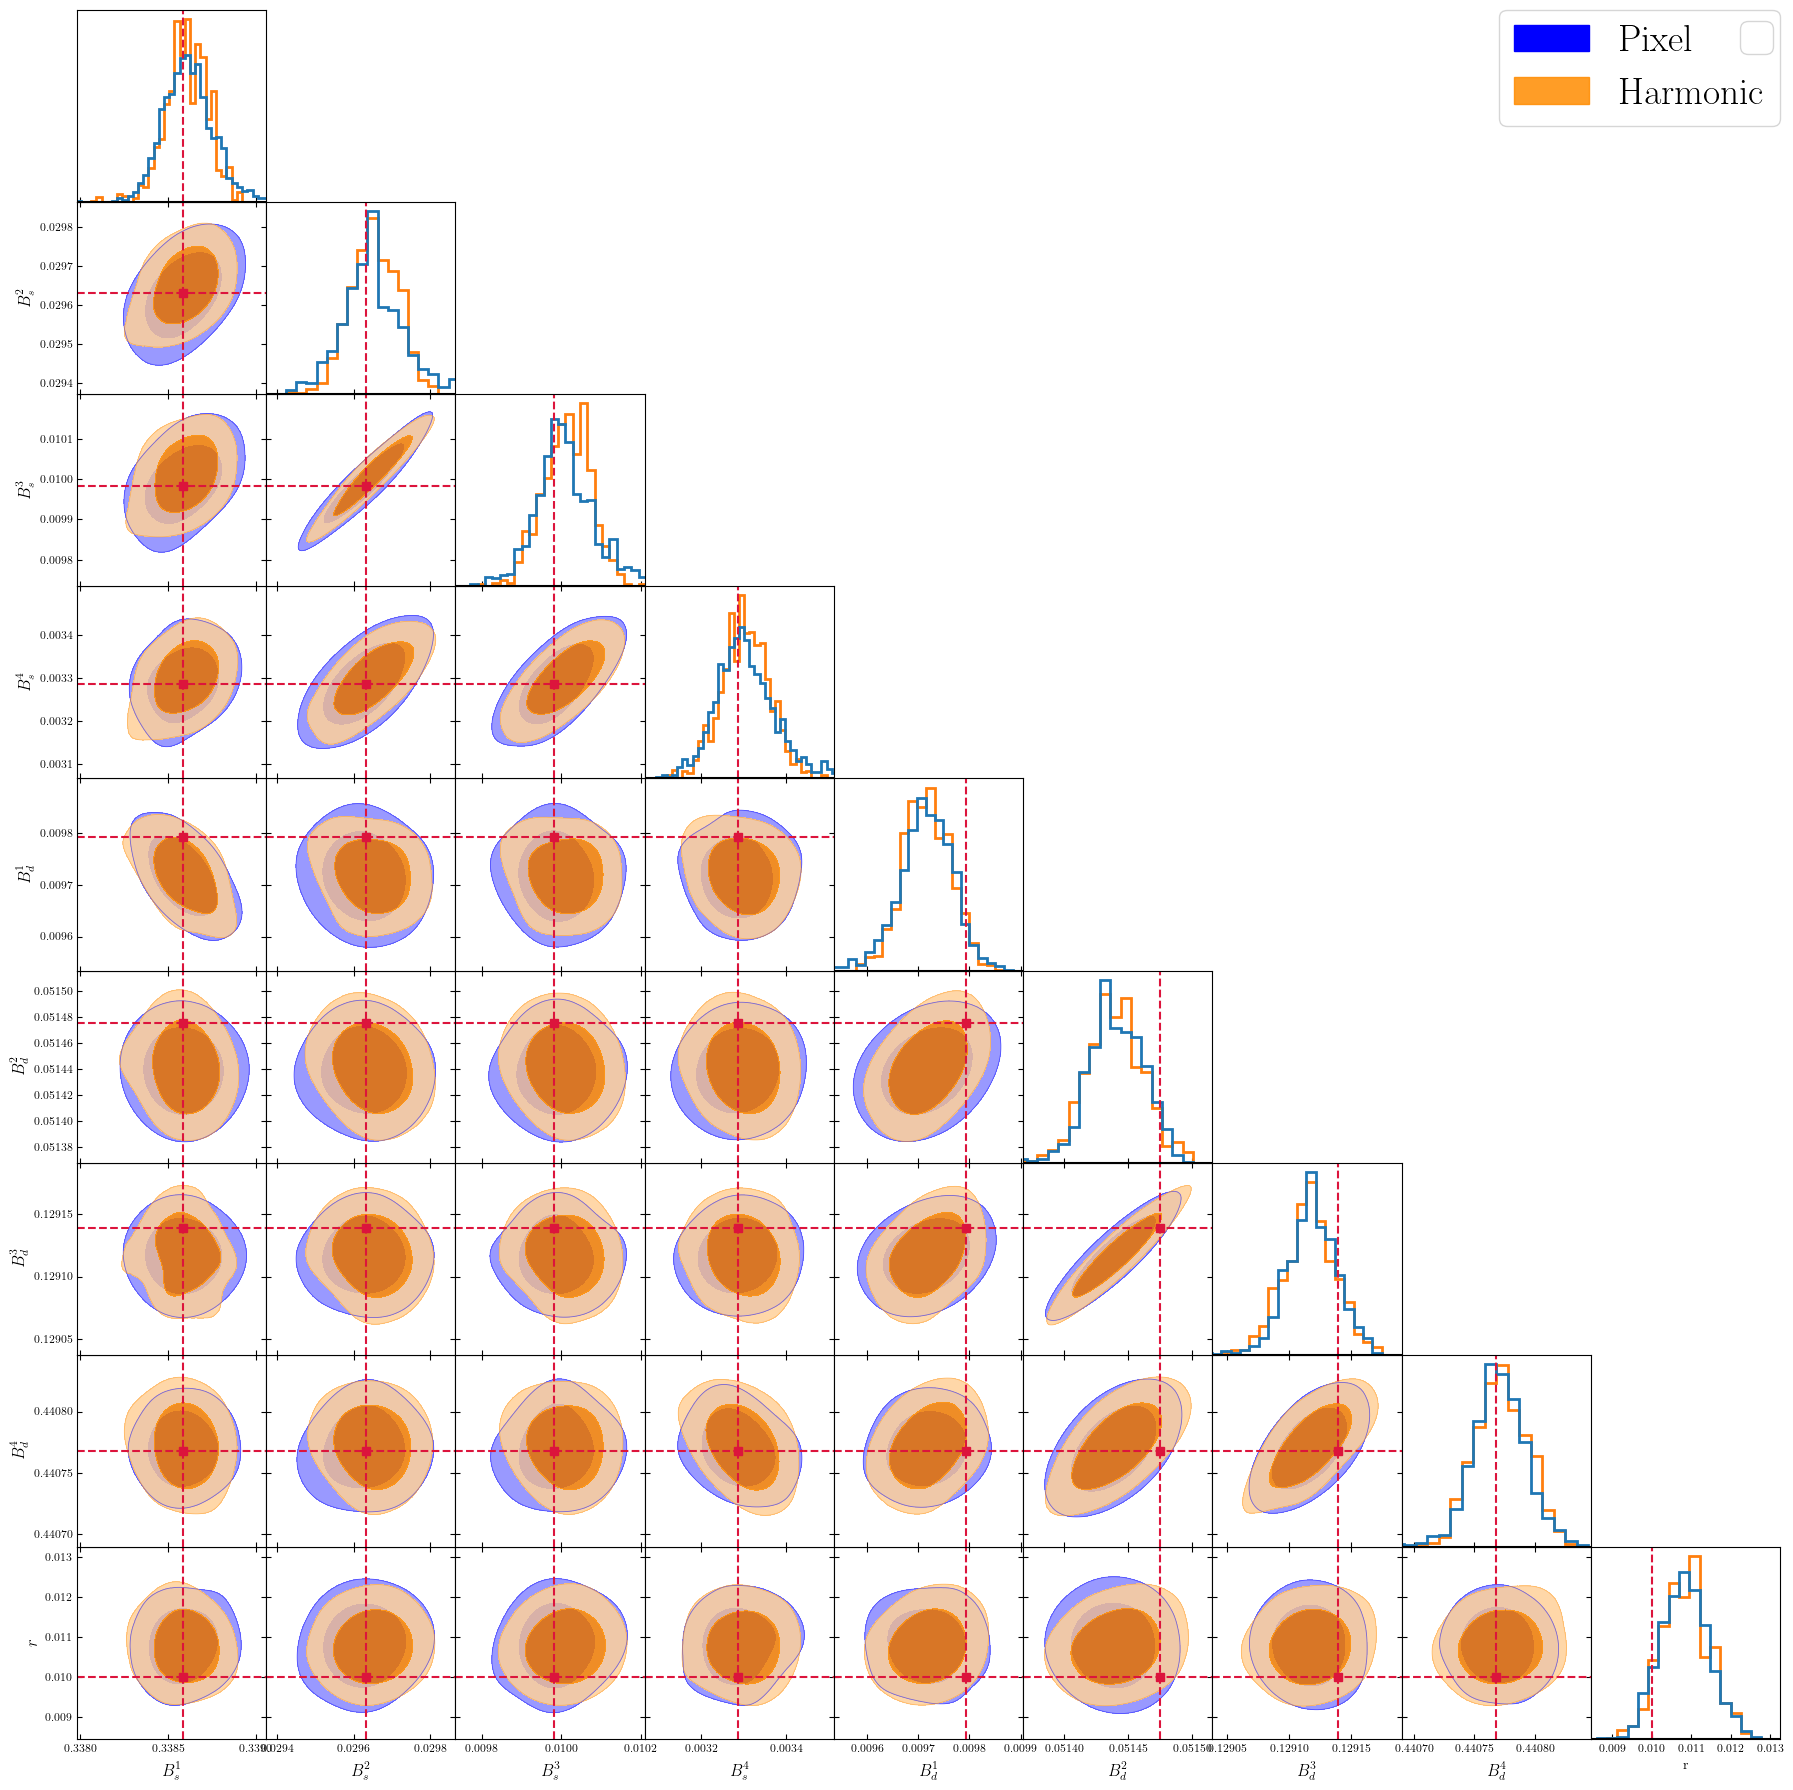

In [107]:
levels = [0.95, 0.66]
# x_gd = [MCSamples(samples=all_samples_file[i], names=names, labels=lab) for i in np.arange(all_samples_file.shape[0])]
# x_gd = [MCSamples(samples=all_samples, names=names, labels=lab, ignore_rows=0.2)]
# x_gd = [MCSamples(samples=all_samples, names=names, labels=lab)]
# x_gd = [MCSamples(samples=all_samples[i], names=names, labels=lab) for i in np.arange(all_samples.shape[0])]
# x_gd = [MCSamples(samples=all_samples[i], names=names, labels=lab, name_tag=name_tag_list[i], ignore_rows=0.4) for i in np.arange(len(all_samples))]
x_gd = [MCSamples(samples=all_samples[i], names=names, labels=lab, ignore_rows=0.4) for i in np.arange(len(all_samples))]

g=plots.GetDistPlotter()
g.settings.norm_1d_density=True
g.settings.axes_labelsize=15
g.settings.legend_fontsize=30
g.settings.figure_legend_loc='upper right'
# g.triangle_plot(x_gd, legend_labels=name_tag_list, filled=True)
g.triangle_plot(x_gd, filled=True, legend_labels=name_tag_list, contour_colors=['blue', 'darkorange'])

# Extract the axes
axes = np.array(g.subplots).reshape((len(x0), len(x0)))

# Get Fisher and covariance
fisher = np.loadtxt(Fisher_path)# Fisher matrix
cov = np.linalg.inv(fisher)
mean = np.zeros(len(x0))
# cov = np.linalg.inv(fisher)
# mean = np.zeros(len(x0))

# Loop over the diagonal
for i in range(len(x0)):
    ax = axes[i, i]
    xinf, xsup = ax.get_xlim()
    x_fish = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
    ax.clear()
    if x0[i] < xinf:
        xinf = min(xinf, x0[i]*.999)
    if x0[i] > xsup:
        xsup = max(xsup, x0[i]*1.001)
    ax.set_xlim(xinf, xsup)
    # ax.hist(all_samples, 20, density=True, histtype='step', fill=False, linewidth=2.0)
    ax.hist(all_samples[:,:,i].T, bins=40, density=True, histtype='step', fill=False, linewidth=2.0)
    ax.axvline(x0[i], color="crimson", linestyle='--')
    mean[i] = norm.fit(all_samples[:, i], scale=np.sqrt(cov[i, i]))[0]
    # ax.plot(x_fish, gaussian(x_fish, mean[i], np.sqrt(cov[i, i])), 'k', label='Fisher')
    ax.plot(x_fish, gaussian(x_fish, mean[i], np.sqrt(cov[i, i])), 'k')
    handles, labels = ax.get_legend_handles_labels()

    if i == len(x0) - 1:
      ax.set_xlabel(names[-1])

# Loop over the histograms
for yi in range(len(x0)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(x0[xi], color="crimson", linestyle='--')
        ax.axhline(x0[yi], color="crimson", linestyle='--')
        ax.plot(x0[xi], x0[yi], "s", color='crimson')
        # xy_array, z_array, t_contours = gaussian_contour_2d(ax, np.array((mean[xi], mean[yi])), np.array(((cov[xi, xi], cov[xi, yi]), (cov[yi, xi], cov[yi, yi]))), levels)
        # ax.contour(xy_array[0], xy_array[1], z_array, t_contours, linewidths=2.0, colors=['k', 'k'])

fig = plt.gcf()
fig.legend(handles, labels, loc='upper right', fontsize=30)

plt.show()
